## 必要なライブラリのインポート
- numpy,chainer系
- ファイル操作系
- 画像操作

In [1]:
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import iterators, optimizers, training
from chainer.training import extensions
from chainer.cuda import to_cpu

import os
import glob
from PIL import Image

## modelの定義(AlexNetぽい構造の何か)

In [2]:
# class AlexNet(chainer.Chain):
# #     insize = 100
#     def __init__(self):
#         super(AlexNet, self).__init__(
#             conv1=L.Convolution2D(3, 96, 11, stride=4),
#             conv2=L.Convolution2D(96, 256, 5, pad=2),
#             conv3=L.Convolution2D(256, 384, 3, pad=1),
#             conv4=L.Convolution2D(384, 284, 3, pad=1),
#             conv5=L.Convolution2D(284, 256, 3, pad=1),
#             fc6=L.Linear(1024, 4096),
#             fc7=L.Linear(4096, 1024),
#             fc8=L.Linear(1024, 3),
#         )

#     def __call__(self, x, t=None):
#         h = x
#         h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv1(h))), 3, stride=2)
#         h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv2(h))), 3, stride=2)
#         h = F.relu(self.conv3(h))
#         h = F.relu(self.conv4(h))
#         h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
#         h = F.dropout(F.relu(self.fc6(h)))
#         h = F.dropout(F.relu(self.fc7(h)))
#         if t is not None:
#             loss = F.softmax_cross_entropy(h, t)
#             chainer.report({'loss': loss, 'accuracy': F.accuracy(h, t)}, self)
#             return loss
#         else:
#             return to_cpu(F.softmax(self.fc8(h)).data)

In [4]:
class AlexNet(chainer.Chain):
#     insize = 100
    def __init__(self):
        super(AlexNet, self).__init__(
            conv1=L.Convolution2D(3, 96, 11, stride=4),
            conv2=L.Convolution2D(96, 256, 5, pad=2),
            conv3=L.Convolution2D(256, 384, 3, pad=1),
            conv4=L.Convolution2D(384, 384, 3, pad=1),
            conv5=L.Convolution2D(384, 256, 3, pad=1),
            fc6=L.Linear(9216, 4096),
            fc7=L.Linear(4096, 1024),
            fc8=L.Linear(1024, 5),
        )

    def __call__(self, x, t=None):
        h = x
        h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv1(h))), 3, stride=2)
        h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv2(h))), 3, stride=2)
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
        h = F.dropout(F.relu(self.fc6(h)))
        h = F.dropout(F.relu(self.fc7(h)))
        if t is not None:
            loss = F.softmax_cross_entropy(h, t)
            chainer.report({'loss': loss, 'accuracy': F.accuracy(h, t)}, self)
            return loss
        else:
            return to_cpu(F.softmax(self.fc8(h)).data)

## データセットのディレクトリ名の取得
以降、ディレクトリごとにラベルつけていく

In [5]:
dataset_dir = "dataset"
# label_names = os.listdir(dataset_dir)
label_names = ["105-1", "798-0", "797-0", "445-0", "233-0"]

In [6]:
# label_names = label_names[0:2]

In [7]:
_labels = []
_images = []

In [8]:
for i, label in enumerate(label_names):
    for f in glob.glob("%s/%s/*"%(dataset_dir,label)):
        img = Image.open(f)
        img = np.array(img.resize((227,227)))
        for j in range(20):
            _labels.append(i)
            _images.append(img)

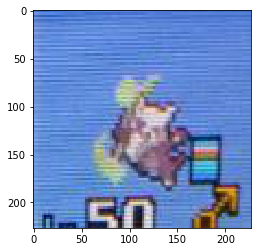

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(_images[0])

In [10]:
# 正規化
images = np.array(_images, dtype=np.float32) / 255.0
labels = np.array(_labels, dtype=np.int32)

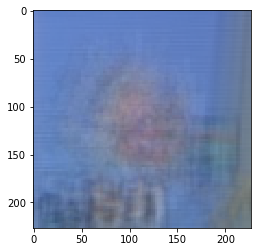

In [11]:
mean_img = np.mean(images, axis=0)
plt.imshow(mean_img)

In [12]:
for i in range(len(images)):
    images[i] = images[i] - mean_img

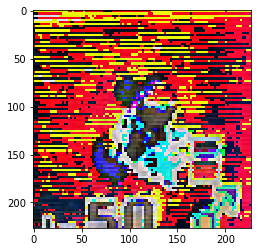

In [13]:
plt.imshow(images[0])

## chainerで扱えるようにRGBの層を手前に持ってくる

In [14]:
images = images.transpose(0,3,1,2)

In [15]:
images[0].shape
labels.shape

(760,)

## 画像と正解ラベルのペアを作成する

In [16]:
x_train = chainer.datasets.TupleDataset(images, labels)

In [17]:
x_train[0]

(array([[[-0.0777081 , -0.0777081 , -0.09483987, ..., -0.11320958,
          -0.12652254, -0.12652254],
         [-0.0777081 , -0.0777081 , -0.09483987, ..., -0.11320958,
          -0.12652254, -0.12652254],
         [ 0.0251804 ,  0.0251804 ,  0.00113565, ..., -0.07265279,
          -0.08720383, -0.08720383],
         ..., 
         [-0.03591305, -0.03591305,  0.0054704 , ..., -0.03622395,
          -0.03302372, -0.03302372],
         [ 0.09329167,  0.09329167,  0.12301305, ..., -0.04582116,
          -0.03993964, -0.03993964],
         [ 0.09329167,  0.09329167,  0.12301305, ..., -0.04582116,
          -0.03993964, -0.03993964]],
 
        [[-0.02796748, -0.02796748, -0.04902002, ..., -0.01197106,
          -0.02507815, -0.02507815],
         [-0.02796748, -0.02796748, -0.04902002, ..., -0.01197106,
          -0.02507815, -0.02507815],
         [ 0.06336361,  0.06336361,  0.05077279, ...,  0.02858561,
           0.01455075,  0.01455075],
         ..., 
         [ 0.00887388,  0.00887

## 入力に渡すiteratorの作成

In [19]:
train_iter = iterators.SerialIterator(x_train, batch_size=100, shuffle=True)

## modelの作成

In [20]:
model = AlexNet()

## 最適化手法の選択

In [21]:
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(0.0001))

## undaterとtrainerの作成
device=0で処理が0番GPUに投げられるはず  
訓練結果はresultディレクトリに作成されるはず

In [22]:
updater = training.StandardUpdater(train_iter, optimizer, device=0)

/home/c0115334ef/anaconda3/lib/python3.6/site-packages/chainer/cuda.py:84: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cupy-with-cudnn-and-nccl).
  'cuDNN is not enabled.\n'


In [23]:
trainer = training.Trainer(updater, (100, 'epoch'), out='result')

## Logの出力設定

In [24]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss']))
trainer.extend(extensions.ProgressBar())

In [25]:
trainer.run()

epoch       main/accuracy  main/loss 
1           0.16625        9.61039     
2           0.18875        5.81328     
3           0.214286       5.14717     
4           0.2275         4.73507     
5           0.237143       4.87212     
6           0.2125         4.71572     
7           0.23875        4.62849     
8           0.277143       4.33685     
9           0.28125        4.45222     
10          0.345714       4.27701     
11          0.40375        4.21709     
12          0.46875        4.08055     
13          0.537143       3.38998     
     total [######............................................] 13.16%
this epoch [#######...........................................] 15.79%
       100 iter, 13 epoch / 100 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
14          0.5125         3.53281     
15          0.514286       3.44971     
16          0.54875        3.24663     
17          0.5275         3.52419     
18          0.542857       3.42941     
19  

## 【祝】訓練データに対する判別率10%突破！

In [26]:
from chainer import cuda

true_label 1
network's output
0.5
0.5
0


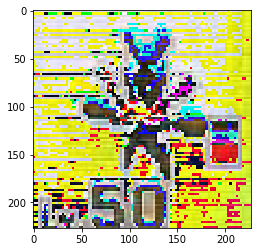

In [75]:
img, label = x_train[200]
plt.imshow(img.transpose(1,2,0))
model.train=False
cuda.check_cuda_available()
cuda.get_device(0).use()
xp = cuda.cupy
# img = Image.open("./dataset/445-0.jpg").resize((227,227))
# img = np.array(img, dtype=np.float32) / 255
# img = img.transpose(2,0,1)
print("true_label",label)
print("network's output")
out = model(xp.asarray(img[None,:]))
print(out[0,0])
print(out[0,1])
print(np.argmax(out))